# Pré processamento

In [1]:
# Importando as bibliotecas e construindo o dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import faiss
import random
from sklearn.impute import KNNImputer
from sentence_transformers import SentenceTransformer
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns

/Users/joaomadruga/.pyenv/versions/3.10.4/envs/default/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# concatenando dois dataframes (um com fake news e outro com noticias verdadeiras)
fake_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/Fake.csv')
true_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/True.csv')
# adicionando coluna label, correspondente a veracidade da noticias (1 para verdadeiro e 0 para falsa)
fake_df['label'] = 0
true_df['label'] = 1

combined_df = pd.concat([fake_df, true_df], ignore_index=True)

combined_df.to_csv('Combined.csv', index=False)
combined_df.reset_index(drop=True,inplace=True)
combined_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia

In [3]:
# criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia
import re
# regex para substituir caracteres que não forem letras e números
regex = r'[^a-zA-Z0-9\s]'
combined_df['text'] = combined_df['text'].map(lambda x: re.sub(regex, '', x))
combined_df['num_of_words'] = combined_df['text'].map(lambda x: len(x.split()))

# Criando nova coluna com texto vetorizado 

In [ ]:
# Initialize the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to vectorize the text
def vectorize_text(text):
    return model.encode(text)

# Apply the function to create a new column with vectorized text
combined_df['text_vector'] = combined_df['text'].map(vectorize_text)
combined_df.to_csv('vectorized_texts.csv', index=False)

# Reading from csv file 

In [4]:
# Função para converter strings de vetores em numpy arrays de forma segura
def str_to_array(vector_str):
    try:
        # Remover caracteres desnecessários e converter a string para um numpy array
        cleaned_str = vector_str.replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ')
        return np.fromstring(cleaned_str, sep=' ')
    except Exception as e:
        print(f"Error converting string to array: {e}")
        return np.nan

def convert_text_vectors_from_str_to_np_arr():
    # Certifique-se de que os vetores de texto sejam numpy arrays, não strings
    df['text_vector'] = df['text_vector'].map(str_to_array) if isinstance(df['text_vector'][0], str) else df['text_vector']

    # Verifique se todos os vetores têm o mesmo tamanho
    vector_length = len(df['text_vector'][0])
    df['text_vector'] = df['text_vector'].map(lambda x: x if len(x) == vector_length else np.nan).dropna()

In [5]:
combined_df = pd.read_csv('vectorized.csv')
df = combined_df
convert_text_vectors_from_str_to_np_arr()
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,"[-0.08635634, 0.16764247, 0.40040964, -0.36150..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,"[0.00671101, 0.0081033, -0.20852128, -0.087897..."
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,"[-0.362045884, -0.123025492, -0.551379442, -0...."
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,"[0.0173586905, 0.00204306096, 0.0736115128, 0...."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,"[-0.079019241, 0.473764718, 0.155274183, -0.05..."


# Setando campos como categóricos

In [6]:
combined_df.dtypes

title           object
text            object
subject         object
date            object
label            int64
num_of_words     int64
text_vector     object
dtype: object

In [7]:
# modificando a coluna subject
combined_df.loc[combined_df['subject'].isin(['politics', 'Government News', 'left-news']), 'subject'] = 'politics'
combined_df.loc[combined_df['subject'].isin(['US_News', 'News', 'Middle-east']), 'subject'] = 'worldnews'
combined_df.loc[combined_df['subject'] == 'politicsNews', 'subject'] = 'politics'
combined_df['subject'] = combined_df['subject'].astype('category')

In [8]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
dtype: object

In [9]:
combined_df['num_subjects'] = combined_df['subject'].cat.codes

In [10]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
num_subjects        int8
dtype: object

# Verificando valores nulos e vazios

In [11]:
# verificando valores nulo
combined_df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

In [12]:
# verificando valores vazios de titulo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['title'] = empty_values['title'] == ''
len(empty_values[empty_values['title'] == True])

0

In [13]:
# verificando valores vazios de texto
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['text'] = empty_values['text'] == ''
len(empty_values[empty_values['text'] == True])

631

In [14]:
# verificando valores vazios de tipo de conteúdo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['subject'] = empty_values['subject'] == ''
len(empty_values[empty_values['subject'] == True])

0

In [62]:
# setando valores num_of_words iguais a 0 para nulo
df = combined_df
df['num_of_words'] = df['num_of_words'].map(lambda x: np.nan if x == 0 else x)
df['num_of_words'].isnull().sum()

631

# Dividindo o dataset em batches para otimizar o uso do algoritmo KNN  

In [63]:
batch_size = 5000
df_numpy = df.to_numpy()

# Embaralhar os dados,
np.random.shuffle(df_numpy)
# Dividir o dataset em batches,
n_batches = int(np.ceil(df_numpy.shape[0] / batch_size))  # Número de batches
batches = np.array_split(df_numpy, n_batches)
batches_df = [pd.DataFrame(batch, columns=df.columns) for batch in batches]
df = pd.DataFrame(df_numpy, columns=df.columns)

for batch in batches_df:
    print(batch.isnull().sum())

title            0
text             0
subject          0
date             0
label            0
num_of_words    63
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    67
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    67
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    75
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    79
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    68
text_vector      0
num_subjects     0
dtype: int64
title     

In [64]:
imputer = KNNImputer(n_neighbors=3)
df_num_of_words_knn = [pd.DataFrame(imputer.fit_transform(batch[['num_subjects', 'num_of_words', 'label']]), columns=df[['num_subjects', 'num_of_words', 'label']].columns) for batch in batches_df]


In [65]:
df_concatened = pd.DataFrame()
for batch in df_num_of_words_knn:
    df_concatened = pd.concat([df_concatened, batch], ignore_index=True)
    print(batch.isnull().sum())

num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64


In [66]:
mean_before = df["num_of_words"].mean()
median_before = df["num_of_words"].median()
std_before = df["num_of_words"].std()

mean_after = df_concatened["num_of_words"].mean()
median_after = df_concatened["num_of_words"].median()
std_after = df_concatened["num_of_words"].std()

print(f"Média Antes da imputação: {mean_before}")
print(f"Mediana Antes da imputação: {median_before}")
print(f"Desvio padrão Antes da imputação: {std_before}")

print(f"Média Depois da imputação: {mean_after}")
print(f"Mediana Depois da imputação: {median_after}")
print(f"Desvio padrão Depois da imputação: {std_after}")

Média Antes da imputação: 409.75884970745705
Mediana Antes da imputação: 365.0
Desvio padrão Antes da imputação: 349.71942503433115
Média Depois da imputação: 408.5285164892275
Mediana Depois da imputação: 364.0
Desvio padrão Depois da imputação: 347.9425079925011


In [67]:
df['num_of_words'] = df_concatened['num_of_words']
df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

# Normalização

In [68]:
df

,title,text,subject,date,label,num_of_words,text_vector,num_subjects
0,WATCH: Elizabeth Warren Skewers Donald Trump ...,Senator Elizabeth Warren continued her crusade...,worldnews,"June 27, 2016",0,494.0,"[0.06040979, 0.06019406, 0.04490232, 0.0301119...",1
1,N.J. Democrats divided on renewing 'Bridgegate...,This March 30 story was corrected to note Pri...,politics,"March 30, 2017",1,666.0,"[-0.114649765, 0.0962814987, -0.238213688, -0....",0
2,Maxine Waters Just Threw An EPIC Twitter Bomb...,Rep Maxine Waters is taking a page right out o...,worldnews,"June 7, 2017",0,343.0,"[-0.0309025757, -0.242757395, -0.219708785, 0....",1
3,U.S. lawmakers seek looser energy development ...,WASHINGTON Reuters A bill to ease restriction...,politics,"May 9, 2017",1,398.0,"[0.0339794606, 0.285286129, -0.0969551504, 0.2...",0
4,U.S. SPY SATELLITES Detect North Korea Transfe...,While the main stream media continues to chase...,politics,"Aug 8, 2017",0,398.0,"[-0.31442773, 0.2098737, -0.1797846, -0.121055...",0
...,...,...,...,...,...,...,...,...
44893,"CNN Panel ERUPTS, Gets UGLY After Guest Defen...",Donald Trump s disgusting travel ban is a high...,worldnews,"March 16, 2017",0,385.0,"[0.00566194812, -0.157936513, -0.12730363, 0.0...",1
44894,LIST OF 22 TIMES OBAMA Called Phony Climate Ch...,Oh the irony of a terror attack by Muslims tak...,politics,"Dec 3, 2015",0,1423.0,"[-0.231034383, 0.370221496, -0.245440081, -0.2...",0
44895,Facebook says Russian-linked accounts spent ju...,LONDON Reuters Russianbased operatives placed...,worldnews,"December 13, 2017",1,325.0,"[-0.0436354317, -0.311258584, -0.446187615, -0...",1
44896,Democratic presidential candidates get chance ...,NEW YORK Reuters A US news channel and a news...,politics,"January 26, 2016",1,435.0,"[0.0590595379, -0.16399622, -0.339284927, -0.2...",0


In [69]:
# nomarlizando entre 0 e 1 min-max usando scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df['subject_norm'] = scaler.fit_transform(df[['num_subjects']])
df['num_of_words_norm'] = scaler.fit_transform(df[['num_of_words']])
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm
0,WATCH: Elizabeth Warren Skewers Donald Trump ...,Senator Elizabeth Warren continued her crusade...,worldnews,"June 27, 2016",0,494.0,"[0.06040979, 0.06019406, 0.04490232, 0.0301119...",1,1.0,0.060707
1,N.J. Democrats divided on renewing 'Bridgegate...,This March 30 story was corrected to note Pri...,politics,"March 30, 2017",1,666.0,"[-0.114649765, 0.0962814987, -0.238213688, -0....",0,0.0,0.081886
2,Maxine Waters Just Threw An EPIC Twitter Bomb...,Rep Maxine Waters is taking a page right out o...,worldnews,"June 7, 2017",0,343.0,"[-0.0309025757, -0.242757395, -0.219708785, 0....",1,1.0,0.042113
3,U.S. lawmakers seek looser energy development ...,WASHINGTON Reuters A bill to ease restriction...,politics,"May 9, 2017",1,398.0,"[0.0339794606, 0.285286129, -0.0969551504, 0.2...",0,0.0,0.048886
4,U.S. SPY SATELLITES Detect North Korea Transfe...,While the main stream media continues to chase...,politics,"Aug 8, 2017",0,398.0,"[-0.31442773, 0.2098737, -0.1797846, -0.121055...",0,0.0,0.048886


In [70]:
df['subject_norm'].describe()

count    44898.000000
mean         0.462292
std          0.498582
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: subject_norm, dtype: float64

In [71]:
df['num_of_words_norm'].describe()

count    44898.000000
mean         0.050182
std          0.042845
min          0.000000
25%          0.025736
50%          0.044699
75%          0.063046
max          1.000000
Name: num_of_words_norm, dtype: float64

# Discretização

In [72]:
# discretizando com 10 bins com mesmo intervalo
df['num_of_words_dist'] = pd.cut(df['num_of_words'], 10)

In [73]:
df['num_of_words_dist'].value_counts()

num_of_words_dist
(-7.121, 813.1]     41552
(813.1, 1625.2]      2984
(1625.2, 2437.3]      201
(2437.3, 3249.4]       76
(3249.4, 4061.5]       44
(4061.5, 4873.6]       13
(4873.6, 5685.7]       12
(5685.7, 6497.8]        6
(6497.8, 7309.9]        6
(7309.9, 8122.0]        4
Name: count, dtype: int64

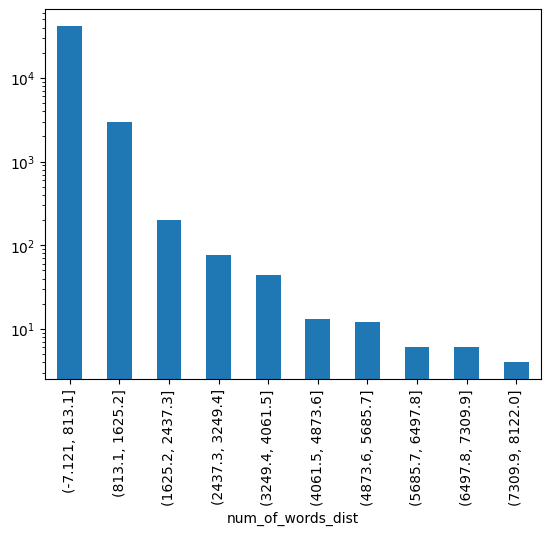

In [74]:
df['num_of_words_dist'].value_counts().plot(kind="bar")
plt.yscale("log")

# Detecção de outliers

In [75]:
df_without_text_vectors = df.drop(columns=['text_vector'])
duplicates = df[df_without_text_vectors.duplicated()]
duplicates

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist
669,Highlights: The Trump presidency on April 13 a...,Reuters Highlights for US President Donald Tr...,politics,"April 13, 2017",1,391.0,"[-0.28289205, 0.06882348, 0.11385614, -0.19529...",0,0.0,0.048024,"(-7.121, 813.1]"
1194,EGYPTIAN COURT SENTENCES MUSLIM BROTHERHOOD LE...,But wait wasn t the Muslim Brotherhood s Arab ...,politics,"Apr 11, 2015",0,622.0,"[-0.0612965338, 0.380214423, -0.270221978, -0....",0,0.0,0.076468,"(-7.121, 813.1]"
1311,Did UPS Secretly Fly “Refugees” Into U.S. From...,So far this video has over 530000 views Does t...,politics,"Feb 7, 2016",0,890.0,"[-0.0293401219, -0.0632017478, -0.647458017, -...",0,0.0,0.109469,"(813.1, 1625.2]"
1441,Woman Just Rescued from #Harvey Flood Goes Off...,A clueless CNN reporter trying to interview a ...,politics,"Aug 29, 2017",0,121.0,"[-0.2928205, -0.22666755, -0.3233505, -0.02258...",0,0.0,0.014777,"(-7.121, 813.1]"
1785,[VIDEO] BLACK TWO-TIME OBAMA VOTER LASHES OUT:...,The tide is turning and the Democrats are losi...,politics,"Jan 7, 2016",0,294.0,"[-0.0381252728, 0.342000484, 0.0210646987, 0.0...",0,0.0,0.036079,"(-7.121, 813.1]"
...,...,...,...,...,...,...,...,...,...,...,...
44881,LORETTA LYNCH Makes Disturbing VIDEO Encouragi...,Obama s former AG Loretta Lynch released a vid...,politics,"Mar 4, 2017",0,249.0,"[-0.118465193, -0.167938143, -0.568957925, 0.0...",0,0.0,0.030538,"(-7.121, 813.1]"
44883,Trump’s Latest Tease Pales Next to Bush and Go...,It s teetering on the ridiculous watching the...,worldnews,"October 24, 2016",0,323.0,"[-0.0565587282, -0.396362901, -0.0783270448, -...",1,1.0,0.039650,"(-7.121, 813.1]"
44885,WOW! “We Mexicans Need To Kill Donald Trump Be...,And now a message of peace and unity from one ...,politics,"Sep 8, 2016",0,158.0,"[0.18136603, 0.16673312, -0.04021518, -0.09004...",0,0.0,0.019333,"(-7.121, 813.1]"
44891,ITALIANS FURIOUS! Have You Ever Dreamed Of Liv...,One short trip on a boat and this could be all...,politics,"Jun 6, 2016",0,372.0,"[0.25732937, 0.19754918, -0.03135435, -0.05785...",0,0.0,0.045684,"(-7.121, 813.1]"


In [76]:
duplicates_mask = df_without_text_vectors.duplicated(keep=False)

# Drop duplicates from the original DataFrame
df = df[~duplicates_mask]

In [77]:
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

C:\Users\guiL6\AppData\Local\Temp\ipykernel_19388\4099902805.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicates = df[df_without_text_vectors.duplicated()]


,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist


<Axes: >

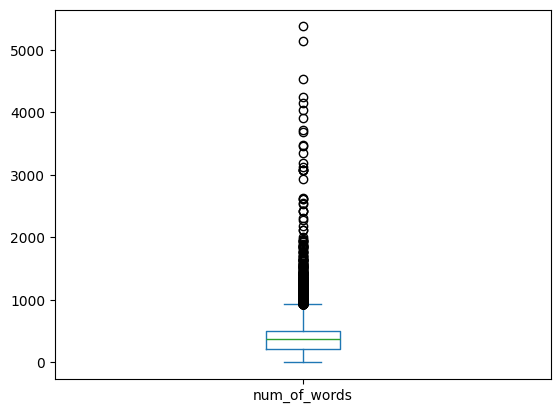

In [78]:
df['num_of_words'].plot.box()

<Axes: ylabel='Frequency'>

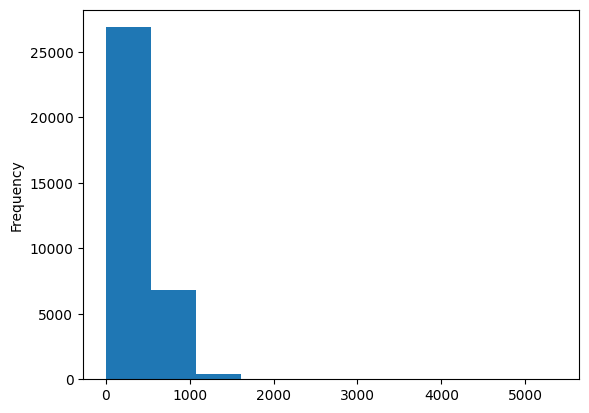

In [79]:
df['num_of_words'].plot.hist()

C:\Users\guiL6\AppData\Local\Temp\ipykernel_19388\1135887764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_num_of_words'] = np.log10(df['num_of_words'])


<Axes: ylabel='Frequency'>

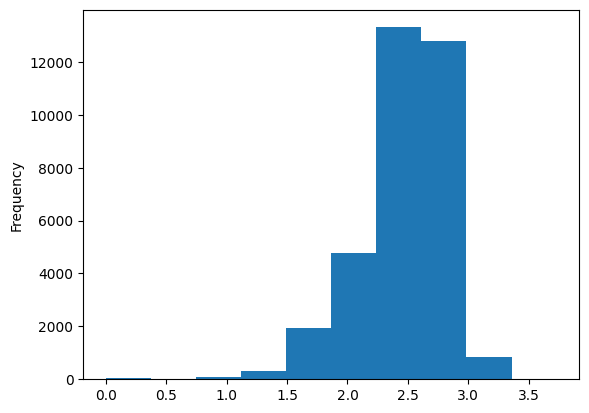

In [80]:
df['log_num_of_words'] = np.log10(df['num_of_words'])
df['log_num_of_words'].plot.hist()

### A coluna é simétrica e univariada, então pode-se utilizar o Z-Score robusto

In [81]:
mad = np.abs(df['log_num_of_words'] - df['log_num_of_words'].median()).median()*(1/0.6745)
print(mad)

0.24288117937957474


<Axes: >

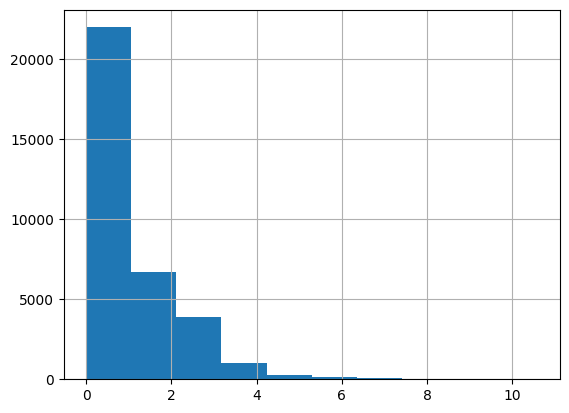

In [82]:
(np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad).hist()

In [83]:
df[np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad > 3.5]

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
12,Russian Defense Minister meets U.S. envoy to M...,MOSCOW Reuters Russian Defense Minister Serge...,worldnews,"November 2, 2017",1,49.0,"[-0.14107418, 0.2368452, -0.06714316, 0.371900...",1,1.0,0.005911,"(-7.121, 813.1]",1.690196
38,OBAMA DOUBLES DOWN On The Threat Of Climate Ch...,The political ideology is shocking A Very stub...,politics,"Dec 4, 2015",0,46.0,"[-0.21024546, -0.0505235158, -0.23369953, 0.01...",0,0.0,0.005541,"(-7.121, 813.1]",1.662758
120,NAILS IT! FRESHMAN SENATOR Schools Liberal Pun...,Nebraska Senator Ben Sasse gives a fantastic a...,politics,"Feb 5, 2016",0,35.0,"[-0.0849801376, -0.190250278, -0.699679971, -0...",0,0.0,0.004187,"(-7.121, 813.1]",1.544068
152,HOW DOES YOUR STATE’S ECONOMY RANK? Washington...,Thanks to Obama s promise to shut down the coa...,politics,"Aug 3, 2015",0,4148.0,"[0.106309682, -0.22381942, 0.00234342832, 0.01...",0,0.0,0.510651,"(4061.5, 4873.6]",3.617839
154,WATCH CROOKED HILLARY Make Claim No Lives Lost...,What about Chris Stevens Sean Smith Glen Doher...,politics,"Jun 9, 2016",0,11.0,"[0.3314974, -0.120397, -0.6078164, -0.20123106...",0,0.0,0.001231,"(-7.121, 813.1]",1.041393
...,...,...,...,...,...,...,...,...,...,...,...,...
44736,WIKILEAKS: No Stamina? Hillary’s Aide Asked To...,Via Wikileaks,politics,"Oct 17, 2016",0,2.0,"[-0.527497351, -0.374455482, -0.239364222, 0.0...",0,0.0,0.000123,"(-7.121, 813.1]",0.301030
44801,Wow! Ted Cruz Blasts CNBC Anchor Over Ridiculo...,Ted Cruz takes the CNBC debate hosts to task o...,politics,"Oct 28, 2015",0,18.0,"[0.04039221, -0.14454122, -0.1376728, 0.214977...",0,0.0,0.002093,"(-7.121, 813.1]",1.255273
44813,LISTEN UP! CHAIRMAN FOR TEENS FOR TRUMP Sends ...,CJ Pierson is such a great kid he s sending me...,politics,"Aug 13, 2016",0,30.0,"[-0.189118415, 0.18278794, -0.150763407, -0.22...",0,0.0,0.003571,"(-7.121, 813.1]",1.477121
44843,Putin to meet Erdogan in Ankara on Sept 28: Kr...,MOSCOW Reuters Russia s president Vladimir Pu...,worldnews,"September 25, 2017",1,51.0,"[0.310425, 0.07456954, -0.2624454, 0.33697048,...",1,1.0,0.006157,"(-7.121, 813.1]",1.707570


In [84]:
len(df)

34132

In [85]:
df = df[abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad < 3.5]

In [86]:
len(df)

33103

# Gerando análises de similaridade

In [40]:
from scipy.stats import ttest_ind

# Convert the list of vectors to a numpy array
vectors = np.vstack(df['text_vector'].to_numpy())

# Build the FAISS index
dimension = vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors)

In [41]:
# Selecionando 1000 notícias falsas e 1000 verdadeiras para cada assunto
fake_data = df[df['label'] == 0].groupby('subject').sample(1000)  # Seleciona 1000 notícias falsas para cada assunto
true_data = df[df['label'] == 1].groupby('subject').sample(1000)  # Seleciona 1000 notícias verdadeiras para cada assunto

# Concatenando os dados selecionados
selected_data = pd.concat([fake_data, true_data])  # Combina as notícias falsas e verdadeiras em um único DataFrame

# Listas para armazenar as similaridades
fake_vs_fake_similarities = []  # Lista para armazenar similaridades entre notícias falsas
true_vs_true_similarities = []  # Lista para armazenar similaridades entre notícias verdadeiras
true_vs_fake_similarities = []  # Lista para armazenar similaridades entre notícias verdadeiras e falsas

for subject in ['politics', 'worldnews']:
    # Obter os índices das notícias falsas e verdadeiras para o assunto atual
    fake_indices = fake_data[fake_data['subject'] == subject].index  # Índices das notícias falsas do assunto atual
    true_indices = true_data[true_data['subject'] == subject].index  # Índices das notícias verdadeiras do assunto atual
    
    # Loop para calcular similaridades entre notícias falsas
    for fake_index in fake_indices:
        query_vector = selected_data[selected_data.index == fake_index]['text_vector'].iloc[0]  # Vetor de texto da notícia falsa atual
        distances, indices = index.search(np.array([query_vector]), len(selected_data))  # Busca as distâncias e índices das notícias mais similares
        
        # Encontrar similaridades falsas vs falsas
        fake_vs_fake_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in fake_indices])  # Armazena similaridades entre notícias falsas
        
        # Encontrar similaridades falsas vs verdadeiras
        true_indices_in_results = [i for i in indices[0] if i in true_indices]  # Índices das notícias verdadeiras nos resultados da busca
        if true_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(true_indices_in_results[0])])  # Armazena a similaridade entre a notícia falsa e a primeira notícia verdadeira encontrada
    
    # Loop para calcular similaridades entre notícias verdadeiras
    for true_index in true_indices:
        query_vector = selected_data[selected_data.index == true_index]['text_vector'].iloc[0]  # Vetor de texto da notícia verdadeira atual
        distances, indices = index.search(np.array([query_vector]), len(selected_data))  # Busca as distâncias e índices das notícias mais similares
        
        # Encontrar similaridades verdadeiras vs verdadeiras
        true_vs_true_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in true_indices])  # Armazena similaridades entre notícias verdadeiras
        
        # Encontrar similaridades verdadeiras vs falsas
        fake_indices_in_results = [i for i in indices[0] if i in fake_indices]  # Índices das notícias falsas nos resultados da busca
        if fake_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(fake_indices_in_results[0])])  # Armazena a similaridade entre a notícia verdadeira e a primeira notícia falsa encontrada

# Estatísticas descritivas

## Histograma de distribuição do número de palavras

O histograma ilustra a distribuição do número de palavras após uma transformação logarítmica. A maioria dos textos concentra-se em torno de cerca de 6 palavras, com uma diminuição gradual na frequência à medida que o número de palavras aumenta. Textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras) são menos comuns. Em suma, a análise revela que a maioria dos textos possui um número moderado de palavras, com uma concentração significativa em torno de 6 palavras, destacando a predominância de textos de comprimento médio.

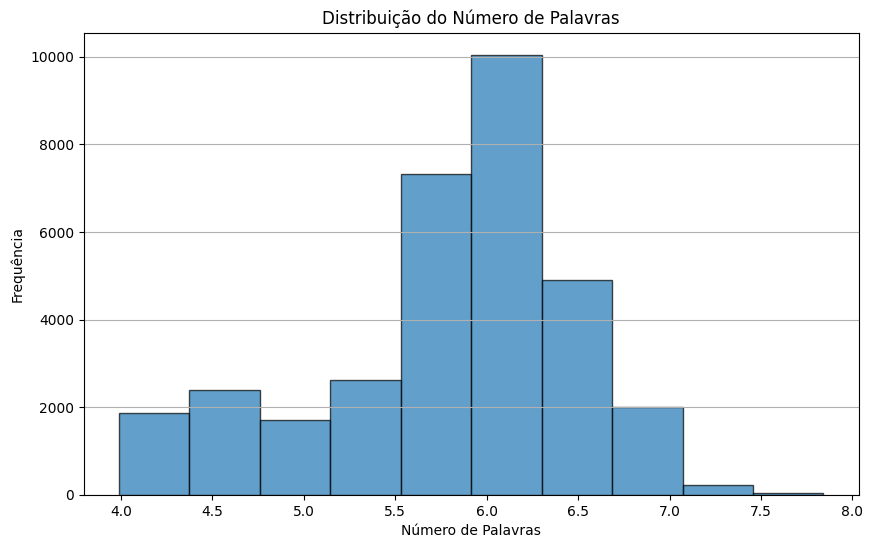

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['num_of_words']), bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

## Boxplot representando o número de palavras

O boxplot mostra a distribuição do número de palavras em textos após uma transformação logarítmica. A mediana é cerca de 6, sugerindo que a maioria dos textos tem em torno de 6 palavras. A caixa do boxplot, entre o primeiro e terceiro quartil, indica que 50% dos textos possuem entre aproximadamente 5 e 6,5 palavras. Os "whiskers" indicam a variação esperada dos dados até 1,5 vezes o intervalo interquartil (IQR). Além disso, há outliers representando textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras). Em síntese, a análise revela que a maioria dos textos tem um número moderado de palavras, com a predominância de textos de comprimento médio, sendo textos extremamente curtos ou longos menos frequentes.

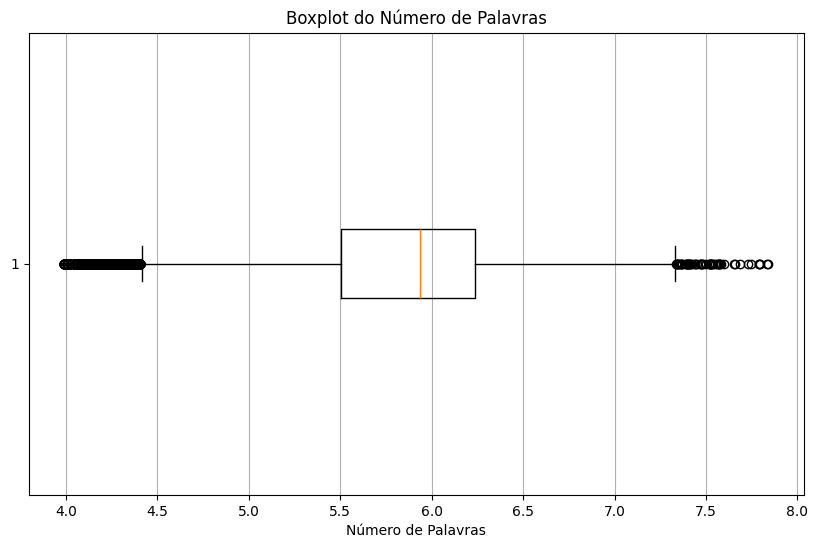

In [43]:
# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(np.log(df['num_of_words']), vert=False)
plt.title('Boxplot do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.grid(axis='x')
plt.show()

## Gráfico de barras comparando o número de notícias falsas vs verdadeiras por ano

O gráfico abaixo compara o número de notícias falsas e verdadeiras publicadas anualmente de 2015 a 2018. 
As conclusões são:

2015: Poucas notícias, com ligeira predominância das falsas.
2016: Aumento significativo de notícias, com mais falsas do que verdadeiras.
2017: Pico de notícias, com um aumento expressivo em ambas as categorias, sendo as verdadeiras consideravelmente mais numerosas.
2018: Poucas notícias, tanto falsas quanto verdadeiras, indicando baixa coleta de dados ou atividade mínima.

Em resumo, o período de 2016 a 2017 registrou um aumento acentuado na produção ou coleta de notícias, com destaque para 2017, especialmente para as notícias verdadeiras.

In [44]:
date_formats = ['%B%d,%Y', '%d-%b-%y', '%B%d,%Y', '%b%d,%Y', '%d-%b-%Y', '%d%B%Y', '%d%b%Y', '%Y-%m-%d', '%m-%d-%Y', '%Y/%m/%d', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y']

def is_valid_date(date_str):
    for format_str in date_formats:
        try:
            return pd.to_datetime(re.sub(r'\s+', '', str(date_str)), format=format_str)
        except ValueError:
            pass

    return pd.NaT

valid_dates = df.copy()
valid_dates['date'] = valid_dates['date'].map(is_valid_date)
valid_dates['year'] = valid_dates['date'].dt.year

<Figure size 1200x600 with 0 Axes>

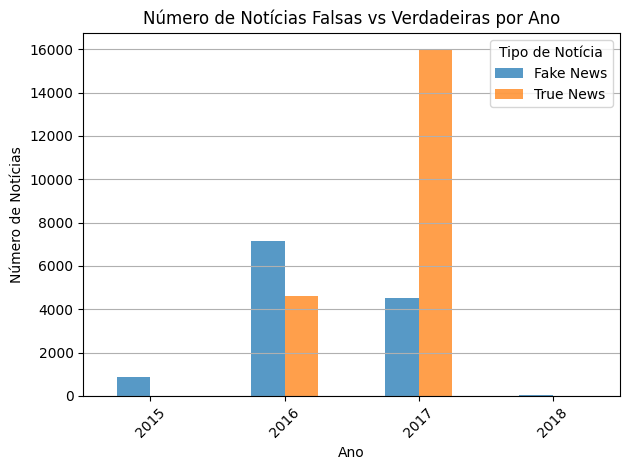

In [45]:
# Contar o número de notícias falsas e verdadeiras por ano
fake_news_per_year = valid_dates[valid_dates['label'] == 0].groupby('year').size()
true_news_per_year = valid_dates[valid_dates['label'] == 1].groupby('year').size()

# Criar um DataFrame com esses dados
news_counts_per_year = pd.DataFrame({
    'Fake News': fake_news_per_year,
    'True News': true_news_per_year
}).fillna(0)  # Preencher valores ausentes com 0

# Plotar o gráfico
plt.figure(figsize=(12, 6))
news_counts_per_year.plot(kind='bar', stacked=False, alpha=0.75)
plt.title('Número de Notícias Falsas vs Verdadeiras por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Notícias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Notícia')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Gráfico de Similaridade em Notícias Verdadeiras, Falsas e Mistas

### Descrição dos Gráficos de Similaridade em Notícias Verdadeiras, Falsas e Mistas

O gráfico compara a similaridade das notícias falsas, verdadeiras e mistas em relação aos subjects "worldnews" e "politics". A similaridade é representada pela distância média (quanto menor a distância, maior a similaridade).

### Análise

- Fake vs Fake: Notícias falsas têm uma similaridade moderada, com uma distância média em torno de 20.
- True vs True: Notícias verdadeiras têm a menor similaridade, com a maior distância média, ligeiramente acima de 20.
- True vs Fake: Notícias mistas têm a maior similaridade, com a menor distância média, aproximadamente 15.

### Conclusão

As notícias mistas (verdadeiras vs falsas) mostram maior similaridade entre si, indicando que as notícias verdadeiras e falsas compartilham características comuns. As notícias verdadeiras mantêm menor similaridade quando comparadas entre si, enquanto as notícias falsas também têm uma similaridade moderada dentro do seu grupo.

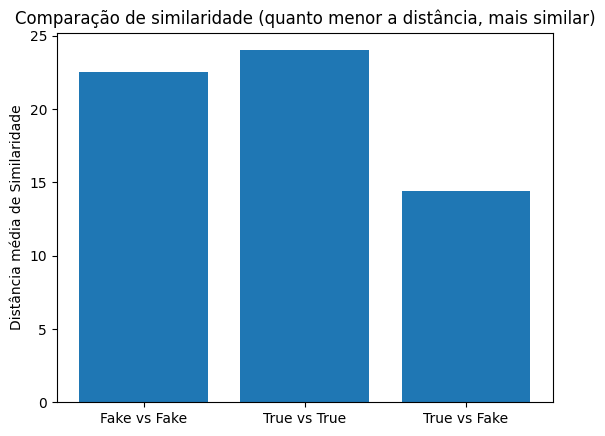

In [46]:
# Calculando as médias das similaridades
labels = ['Fake vs Fake', 'True vs True', 'True vs Fake']
similarities = [np.mean(fake_vs_fake_similarities), np.mean(true_vs_true_similarities), np.mean(true_vs_fake_similarities)]

# Plotando as similaridades
plt.bar(labels, similarities)
plt.ylabel('Distância média de Similaridade')
plt.title('Comparação de similaridade (quanto menor a distância, mais similar)')
plt.show()

# Teste de hipótese

## Teste de Hipótese: Similaridade entre Notícias Verdadeiras, Falsas e Mistas

Nesta seção, realizaremos um teste de hipótese para comparar a similaridade entre notícias verdadeiras, falsas e mistas. A similaridade é medida pela distância média (quanto menor a distância, maior a similaridade). O objetivo é determinar se há uma diferença significativa na similaridade entre as diferentes labels de notícias.

### Passos do Teste de Hipótese

#### Definir Hipóteses:

- \(H_0\) (Hipótese Nula): Não há diferença significativa na similaridade entre as diferentes labels de notícias.
- \(H_a\) (Hipótese Alternativa): Há uma diferença significativa na similaridade entre as diferentes labels de notícias.

#### Calcular as Distâncias Médias:

- Obter as distâncias médias para cada label: Similaridade entre falsas, similaridade entre verdadeiras, e similaridade entre falsas e verdadeiras.

#### Realizar Teste de Hipótese:

- Usar o teste t de Student para comparar as distâncias médias entre as labels.

#### Analisar os Resultados:

- Interpretar os valores p para determinar se rejeitamos ou não a hipótese nula.

## Resultados dos Testes de Hipótese

Os resultados dos testes para comparar as similaridades entre as diferentes categorias de notícias são os seguintes:

### Teste entre Similaridade entre falsas e Similaridade entre verdadeiras:

- T-statistic: -16.37274849962382
- P-value: 1.6354346712162612e-56
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre falsas e a similaridade entre verdadeiras.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre Similaridade entre falsas e Similaridade entre falsas e verdadeiras:

- T-statistic: 25.650055569958536
- P-value: 1.199788220568109e-125
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre falsas e a similaridade entre falsas e verdadeiras.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre Similaridade entre verdadeiras e Similaridade entre falsas e verdadeiras:

- T-statistic: 44.84103110401803
- P-value: 2.239345677091325e-302
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre verdadeiras e a similaridade entre falsas e verdadeiras.
- Observação: O resultado é altamente significativo (p < 0.01).

In [ ]:
def perform_t_test(sample1, sample2, label1, label2):
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    print(f"Teste t de Student entre {label1} e {label2}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}\n")
    
    # Interpretação dos resultados
    alpha = 0.05  # Nível de significância de 5%
    if p_value < alpha:
        print(f"Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre {label1} e {label2}.")
    else:
        print(f"Resultado: Não rejeitamos a hipótese nula. Não há diferença significativa na similaridade entre {label1} e {label2}.")

    # Detalhes adicionais para interpretação
    if p_value < 0.01:
        print("Observação: O resultado é altamente significativo (p < 0.01).")
    elif p_value < 0.05:
        print("Observação: O resultado é estatisticamente significativo (p < 0.05).")
    else:
        print("Observação: O resultado não é estatisticamente significativo (p >= 0.05).")

    print("\n" + "-"*50 + "\n")

# Realizando os testes de hipótese
cropped_sample_fake_vs_fake = random.sample(fake_vs_fake_similarities, 1000) # Similaridade entre falsas
cropped_sample_true_vs_true = random.sample(true_vs_true_similarities, 1000) # Similaridade entre verdadeiras
cropped_sample_true_vs_fake = random.sample(true_vs_fake_similarities, 1000) # Similaridade entre verdadeiras e falsas

perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_true, 'Similaridade entre falsas', 'Similaridade entre verdadeiras')
perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_fake, 'Similaridade entre falsas', 'Similaridade entre verdadeiras e falsas')
perform_t_test(cropped_sample_true_vs_true, cropped_sample_true_vs_fake, 'Similaridade entre verdadeiras', 'Similaridade entre verdadeiras e falsas')

## Teste Qui-Quadrado para Proporção de Notícias Falsas em Textos Curtos e Longos

O código abaixo realiza um teste qui-quadrado de contingência para avaliar a proporção de notícias falsas em textos curtos (com menos de 150 palavras) e longos (com 150 palavras ou mais). Após dividir as notícias em categorias com base no comprimento, são calculadas as proporções de notícias falsas e verdadeiras em cada categoria. O teste estatístico é realizado e o resultado é exibido, mostrando a estatística Qui-Quadrado (Chi2) e o valor P associado. No caso específico deste teste, em que o resultado foi: Chi2 statistic: 188.04, P-value: 0.00000, conclui-se que há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa pode estar associada ao comprimento do texto. As proporções de notícias falsas e verdadeiras são exibidas para ambas as categorias, e é destacado que é mais provável que um texto longo seja uma notícia falsa em comparação a um texto curto, enquanto é mais provável que um texto curto seja uma notícia verdadeira em comparação a um texto longo.

In [ ]:
from scipy.stats import chi2_contingency

# Dividir as notícias em curtas e longas
short_texts = selected_data[selected_data['num_of_words'] < 150]
long_texts = selected_data[selected_data['num_of_words'] >= 150]

# Calcular a proporção de notícias falsas e verdadeiras em cada categoria
short_fake_count = short_texts[short_texts['label'] == 0].shape[0]
short_true_count = short_texts[short_texts['label'] == 1].shape[0]
long_fake_count = long_texts[long_texts['label'] == 0].shape[0]
long_true_count = long_texts[long_texts['label'] == 1].shape[0]

short_fake_proportion = short_fake_count / short_texts.shape[0]
short_true_proportion = short_true_count / short_texts.shape[0]
long_fake_proportion = long_fake_count / long_texts.shape[0]
long_true_proportion = long_true_count / long_texts.shape[0]

# Preparar os dados para o teste qui-quadrado de contingência
contingency_table = pd.DataFrame({
    'Short Texts': [short_fake_count, short_true_count],
    'Long Texts': [long_fake_count, long_true_count]
}, index=['Fake', 'True'])

# Realizar o teste qui-quadrado de contingência
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 statistic: {chi2:.2f}, P-value: {p:.5f}")

if p < 0.05:
    print("Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.")

    print(f"Proporção de notícias falsas entre textos curtos: {short_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos curtos: {short_true_proportion:.2%}")
    print(f"Proporção de notícias falsas entre textos longos: {long_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos longos: {long_true_proportion:.2%}")

    if short_fake_proportion > long_fake_proportion:
        print("É mais provável que um texto curto seja uma notícia falsa comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.")

    if short_true_proportion > long_true_proportion:
        print("É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia verdadeira comparado a um texto curto.")
else:
    print("Não há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa não está associada ao comprimento do texto.")

# Classificação - Projeto 2

In [103]:
# setando label para int, para utilizar o modelo
df['label'] = df['label'].astype('int')
df.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int32
num_of_words          float64
text_vector            object
num_subjects           object
subject_norm          float64
num_of_words_norm     float64
num_of_words_dist    category
log_num_of_words      float64
dtype: object

In [50]:
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
1,Assange says WikiLeaks to release 'significant...,WASHINGTON Reuters WikiLeaks founder and edit...,politics,"August 25, 2016",1,248.0,"[-0.08113641, -0.17954591, -0.1766501, 0.03193...",0,0.0,0.030415,"(-7.121, 813.1]",2.394452
2,"Lebanon, foreign powers urged to maintain non-...",PARIS Reuters World powers sent a clear messa...,worldnews,"December 8, 2017",1,93.0,"[-0.07810178, 0.3529892, -0.05360166, -0.66076...",1,1.0,0.011329,"(-7.121, 813.1]",1.968483
3,"Look Out, Big Oil: ‘Job Creation’ No Longer A...",While jobs in the solar energy sector account ...,worldnews,"May 3, 2016",0,345.0,"[0.0481182225, -0.270775974, 0.150162593, 0.15...",1,1.0,0.042359,"(-7.121, 813.1]",2.537819
4,HARD CORE: Ten GITMO Detainees Released To Oman,Ten more hard core prisoners from GITMO have b...,politics,"Jan 14, 2016",0,190.0,"[-0.03298226, 0.00543272, -0.30223936, -0.2545...",0,0.0,0.023273,"(-7.121, 813.1]",2.278754
5,Tension grips Nigerian city as separatist lead...,UMUAHIA Nigeria Reuters A secessionist leader...,worldnews,"October 3, 2017",1,1086.0,"[-0.13082439, 0.06494011, -0.05707666, -0.0404...",1,1.0,0.133604,"(813.1, 1625.2]",3.035830


In [51]:
x_df = df[['num_of_words_norm','subject_norm']]
y_df = df['label']
xtrain, xtest, ytrain, ytest = train_test_split(x_df, y_df, random_state=1)

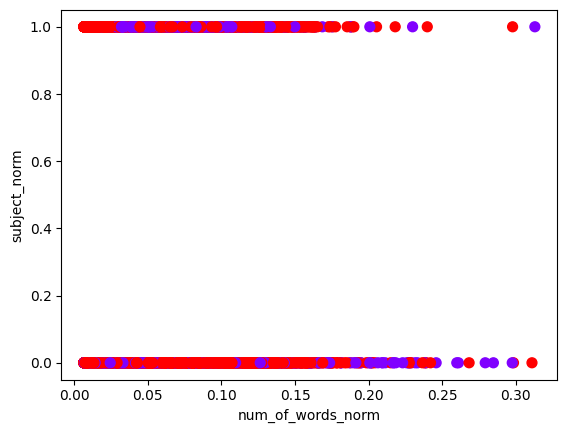

In [52]:
plt.scatter(x_df.iloc[:, 0], x_df.iloc[:, 1], c=y_df, s=50, cmap='rainbow')
plt.xlabel('num_of_words_norm')
plt.ylabel('subject_norm')
plt.show()

In [53]:
print(df['label'].value_counts(normalize=True))
print(f'\nDevido ao desbalanceamento entre as classes, a medição não poderá ser feita por acurácia, como estamos preocupados prioritariamente com o desempenho geral do modelo e sua capacidade de distinguir entre as classes, vamos utilizar a AUC-ROC.')

label
1    0.621338
0    0.378662
Name: proportion, dtype: float64

Devido ao desbalanceamento entre as classes, a medição não poderá ser feita por acurácia, como estamos preocupados prioritariamente com o desempenho geral do modelo e sua capacidade de distinguir entre as classes, vamos utilizar a AUC-ROC.


### Algoritmos

In [54]:
# Define models and hyperparameters
param_grid = {
    "RandomForestClassifier": {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [3, 5, 7]
    },
    "SVC": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'max_iter': [100, 200, 300]
    }
}

models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=1),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "LogisticRegression": LogisticRegression()
}

In [55]:
def find_best_hyper_parameters(models, xtrain, ytrain):
    best_models = {}
    best_auc_roc = 0
    best_model_name = None
    best_model = None

    for model_name, model in models.items():
        print(f"Treinando {model_name}...")
        grid_search = GridSearchCV(model, param_grid[model_name], scoring='roc_auc', cv=5)
        grid_search.fit(xtrain, ytrain)

        best_models[model_name] = grid_search.best_estimator_
        auc_roc = grid_search.best_score_

        print(f"Melhor parâmetro para {model_name}: {grid_search.best_params_}")
        print(f"Validação AUC-ROC para {model_name}: {auc_roc}")

        # Log the results of each grid search with MLflow
        with mlflow.start_run(run_name=f"{model_name}_GridSearch"):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("validation_auc_roc", auc_roc)

        if auc_roc > best_auc_roc:
            best_auc_roc = auc_roc
            best_model_name = model_name
            best_model = grid_search.best_estimator_

    return best_models, best_model


In [56]:
def run_models_using_mlflow(models, xtrain, ytrain, xtest, ytest):
    test_results = {}
    train_results = {} 
    for model_name, model in models.items():
        
        # Predict probabilities for class 1 nos dados de teste
        y_pred_proba_test = model.predict_proba(xtest)[:, 1]
        
        # Calcular AUC-ROC nos dados de teste
        auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

        # Predict probabilities for class 1 nos dados de treino
        y_pred_proba_train = model.predict_proba(xtrain)[:, 1]
        
        # Calcular AUC-ROC nos dados de treino
        auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

        # Log resultados de teste
        test_results[model_name] = auc_roc_test
        print(f"Teste AUC-ROC para {model_name}: {auc_roc_test}")

        # Log resultados de treino
        train_results[model_name] = auc_roc_train
        print(f"Treino AUC-ROC para {model_name}: {auc_roc_train}")

        # Gerar e logar a curva ROC
        fpr, tpr, _ = roc_curve(ytest, y_pred_proba_test)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC Curve (Test AUC = {auc_roc_test:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend()
        plt.show()
        
        # Salvar curva ROC para arquivo
        roc_plot_path = f"roc_curve_{model_name}.png"
        plt.savefig(roc_plot_path)
        plt.close()

        # Gerar e logar a matriz de confusão
        y_pred_test = model.predict(xtest)
        mat = confusion_matrix(ytest, y_pred_test)
        plt.figure(figsize=(8, 6))
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()
        
        # Salvar matriz de confusão para arquivo
        confusion_matrix_plot_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(confusion_matrix_plot_path)
        plt.close()

        # Logar resultados com MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("test_auc_roc", auc_roc_test)
            mlflow.log_metric("train_auc_roc", auc_roc_train)  # Logar AUC-ROC de treino
            mlflow.sklearn.log_model(model, model_name)
            mlflow.log_artifact(roc_plot_path)
            mlflow.log_artifact(confusion_matrix_plot_path)

        # Avaliar overfitting ou underfitting
        if auc_roc_train > auc_roc_test:
            print(f"Warning: {model_name} is overfitting!\n")
        elif auc_roc_train < auc_roc_test:
            print(f"Warning: {model_name} may be underfitting!\n")

    # Determinar o melhor modelo baseado no AUC-ROC de teste
    best_model_name = max(test_results, key=test_results.get)
    print(f"Melhor modelo: {best_model_name} com AUC-ROC: {test_results[best_model_name]}")


In [90]:
mlflow.set_experiment("Multiple Classifier Models")
best_models, best_model = find_best_hyper_parameters(models, xtrain, ytrain)


Treinando RandomForestClassifier...
Melhor parâmetro para RandomForestClassifier: {'max_depth': 10, 'n_estimators': 200}
Validação AUC-ROC para RandomForestClassifier: 0.8009384108619519
Treinando KNeighborsClassifier...
Melhor parâmetro para KNeighborsClassifier: {'n_neighbors': 7}
Validação AUC-ROC para KNeighborsClassifier: 0.7650116079477582
Treinando SVC...
Melhor parâmetro para SVC: {'C': 10, 'kernel': 'rbf'}
Validação AUC-ROC para SVC: 0.722929744931611
Treinando LogisticRegression...
Melhor parâmetro para LogisticRegression: {'C': 10, 'max_iter': 100}
Validação AUC-ROC para LogisticRegression: 0.673124457184479


Teste AUC-ROC para RandomForestClassifier: 0.8026792260875008
Treino AUC-ROC para RandomForestClassifier: 0.8273479502783967


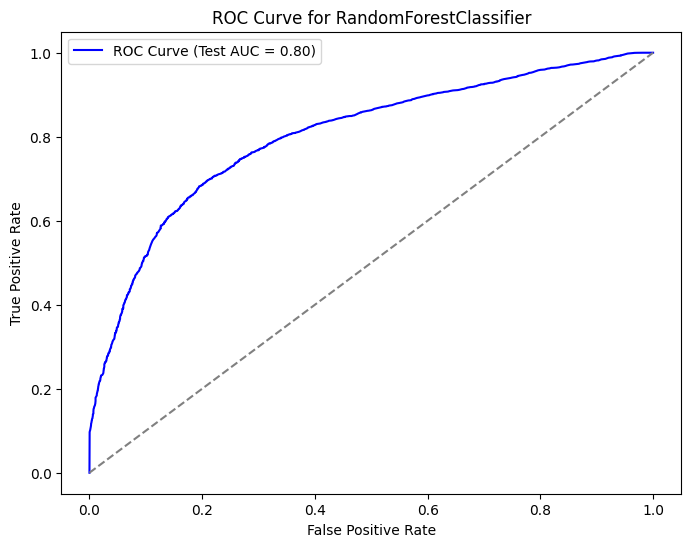

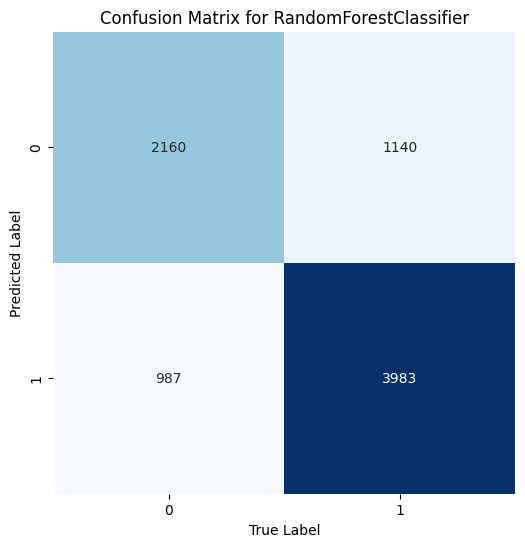


Teste AUC-ROC para KNeighborsClassifier: 0.7702902931699698
Treino AUC-ROC para KNeighborsClassifier: 0.8133430970290083


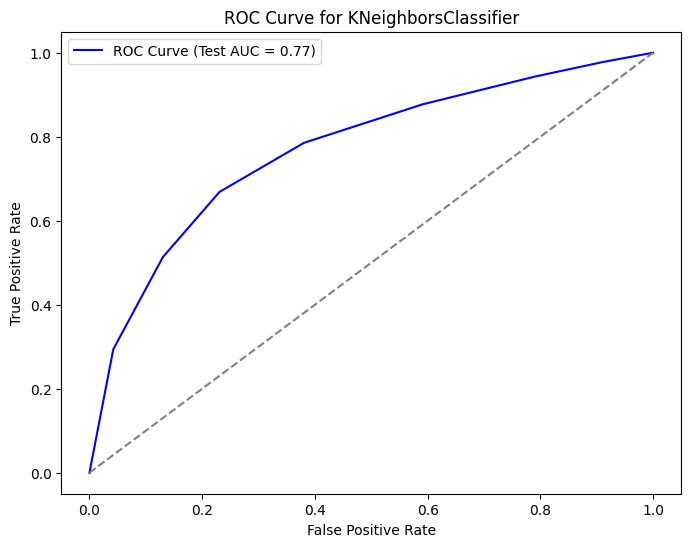

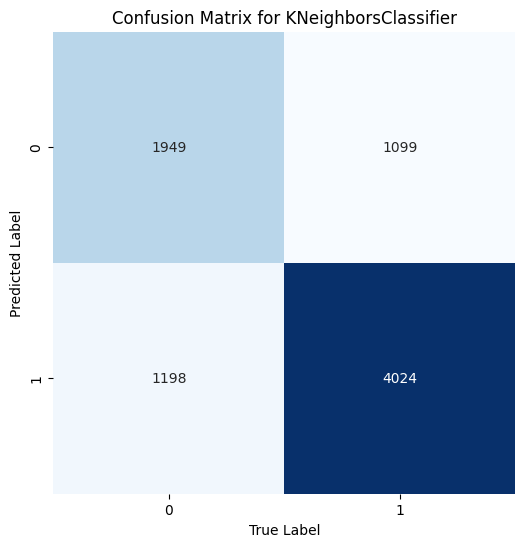


Teste AUC-ROC para SVC: 0.7383837421484237
Treino AUC-ROC para SVC: 0.7282128923272821


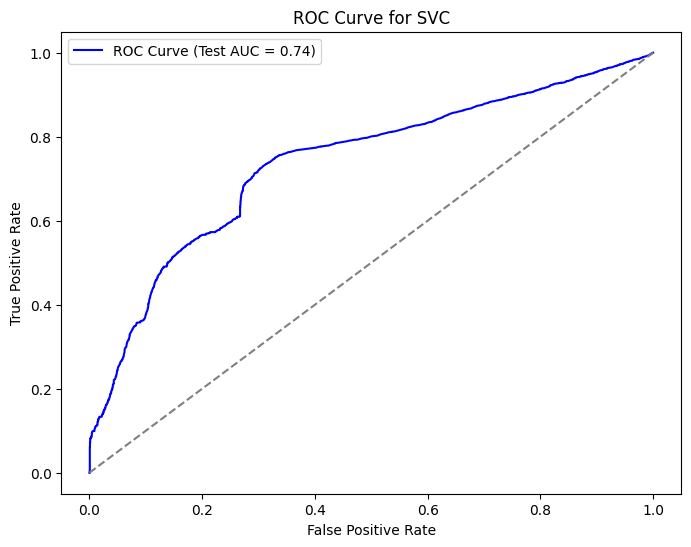

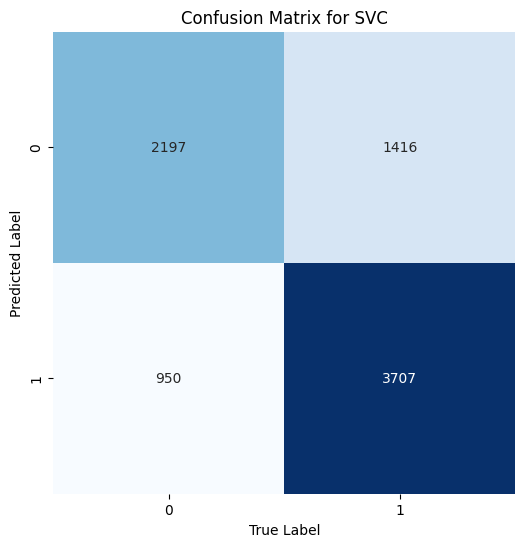


Teste AUC-ROC para LogisticRegression: 0.6777971156453066
Treino AUC-ROC para LogisticRegression: 0.6731212978813748


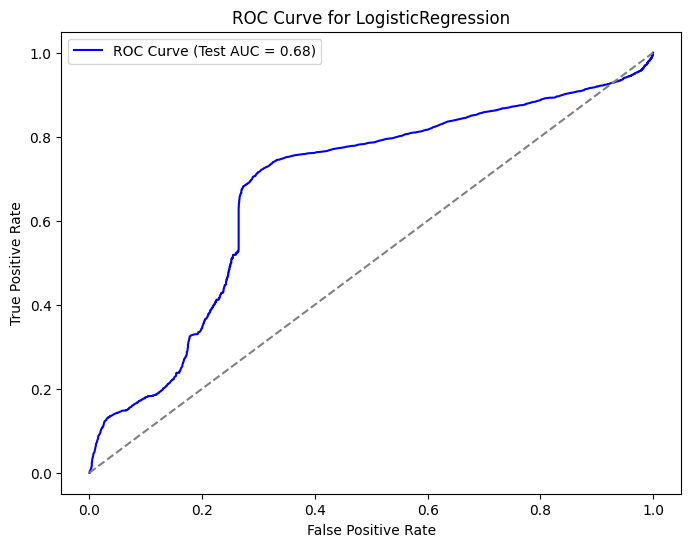

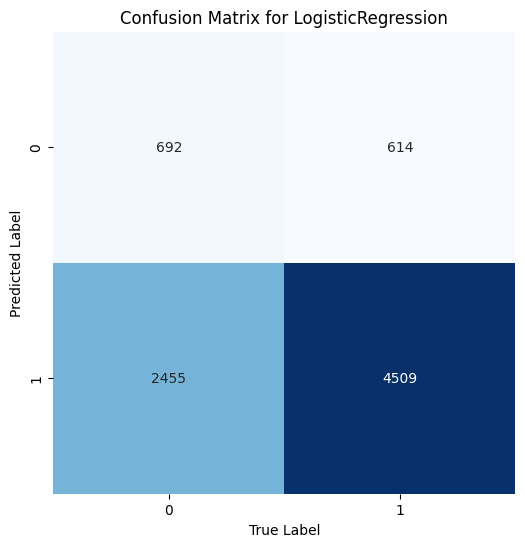


Melhor modelo: RandomForestClassifier com AUC-ROC: 0.8026792260875008


In [91]:
run_models_using_mlflow(best_models, xtrain, ytrain, xtest, ytest)

# Melhora do modelo
Lembrando que o ajuste de hiper parâmetros já foi feito anteriormente, não será necessário o uso dessa técnica. Dado que nosso modelo está tendo overfitting teremos as seguintes técnicas para tentar melhorar o modelo

## Aumento do conjunto de treinamento
O valor default utilizado é tamanho do conjunto de teste em 25%, vamos diminuir para 15%, assim aumentando o tamanho do conjunto de treino

In [114]:
x_df = df[['num_of_words_norm','subject_norm']]
y_df = df['label']
xtrain_modified, xtest_modified, ytrain_modified, ytest_modified = train_test_split(x_df, y_df, random_state=1, test_size=0.15)

In [115]:
best_model.fit(xtrain_modified, ytrain_modified)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = best_model.predict_proba(xtest_modified)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest_modified, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = best_model.predict_proba(xtrain_modified)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain_modified, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.8079906960704282
Treino AUC-ROC : 0.8194479450029218


Resultado: Houve uma diminuição pequena no overfitting do modelo, equilibrando um pouco a validação do conjunto de teste e de treinamento

## Bagging
Ensemble learning que combina múltiplos modelos de machine learning para melhorar a precisão e robustez geral do modelo final. Funciona treinando vários modelos independentes em diferentes subconjuntos aleatórios dos dados de treinamento e depois combinando suas previsões por meio da votação.

In [116]:
from sklearn.ensemble import BaggingClassifier

# Exemplo de Bagging com RandomForestClassifier
bagging_model = BaggingClassifier(estimator=best_model, n_estimators=10, random_state=1)
bagging_model.fit(xtrain, ytrain)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = bagging_model.predict_proba(xtest)[:, 1]
xtrain_modified
# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = bagging_model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.8024080452145105
Treino AUC-ROC : 0.8220149442860333


Resultado: Houve uma diminuição no overfitting do modelo, equilibrando a validação do conjunto de teste e de treinamento

## Balanceamento de Dados
Técnica de oversampling da classe minoritária ou undersampling da classe majoritária para melhorar o desempenho do modelo

In [111]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(x_df, y_df)

model = best_model.fit(X_resampled, y_resampled)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = model.predict_proba(xtest)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")


Teste AUC-ROC : 0.7985036795187916
Treino AUC-ROC : 0.7975577380774912


Resultado: Houve uma melhora do modelo, com a métrica de validação no conjunto de teste maior, significando que  o modelo está generalizando bem para dados não vistos.

## Diminuição da complexidade do modelo
Aumentar min_samples_split e min_samples_leaf em modelos de árvores de decisão limita sua capacidade de se ajustar excessivamente aos dados de treinamento e melhorando sua capacidade de generalização para novos dados.

In [117]:
new_params = {
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

# Adicionando os novos parâmetros ao modelo existente
model = best_model.set_params(**new_params)
model.fit(xtrain, ytrain)
# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = model.predict_proba(xtest)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = model.predict_proba(xtrain)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.8027815391821935
Treino AUC-ROC : 0.8244637573128715


Resultado: Não houve uma melhora do modelo

# Modelo final Junção da técnicas (bagging + balanceamento dos dados + Aumento do conjunto de treinamento)

In [113]:
# Balanceamento dos dados
ros = RandomOverSampler(random_state=1)
x_df_resampled, y_df_resampled = ros.fit_resample(x_df, y_df)

# Aumento do conjunto de treinamento
xtrain_modified, xtest_modified, ytrain_modified, ytest_modified = train_test_split(x_df_resampled, y_df_resampled, random_state=1, test_size=0.15)

# Bagging de RandomForest
bagging_model = BaggingClassifier(estimator=best_model, n_estimators=10, random_state=1)
bagging_model.fit(xtrain_modified, ytrain_modified)

# Predict probabilities for class 1 nos dados de teste
y_pred_proba_test = bagging_model.predict_proba(xtest_modified)[:, 1]

# Calcular AUC-ROC nos dados de teste
auc_roc_test = roc_auc_score(ytest_modified, y_pred_proba_test)

# Predict probabilities for class 1 nos dados de treino
y_pred_proba_train = bagging_model.predict_proba(xtrain_modified)[:, 1]

# Calcular AUC-ROC nos dados de treino
auc_roc_train = roc_auc_score(ytrain_modified, y_pred_proba_train)

# Log resultados de teste
print(f"Teste AUC-ROC : {auc_roc_test}")

# Log resultados de treino
print(f"Treino AUC-ROC : {auc_roc_train}")

Teste AUC-ROC : 0.8119228853176155
Treino AUC-ROC : 0.8188578106504045
